In [1]:
import os, sys, re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from numpy import *
from scipy import fftpack, linalg, integrate, signal
from scipy.constants import eV, c, epsilon_0, elementary_charge, m_e, h, hbar
from scipy.constants import physical_constants
from mendeleev import element
topdir = os.getcwd()

bohr2ang = 0.529178
au2fs = 0.0241888
eV2cm = 8065.6
au2eV = physical_constants['Hartree energy in eV'][0]
au2invcm = physical_constants['hartree-inverse meter relationship'][0]/100
au2perm = physical_constants['atomic unit of permittivity'][0]
Eh = physical_constants['Hartree energy'][0]
a0 = physical_constants['Bohr radius'][0]
amu = physical_constants['atomic mass constant'][0]


def conv_icm2nm(in_arg):
    inp = in_arg
    inp *= au2invcm
    inp = 1/inp
    inp *= 1e7
    return inp

def conv_au2icm(in_arg):
    inp = in_arg
    inp *= au2invcm

    return inp

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [2]:
#Window function to remove artefacts from Gibb's phenomenon
def window_function(sigt1):
    sigma = 0.5
    n = len(sigt1)
    tvals = arange(n, dtype=complex)
    N = n - 1
    sigt2 = sigt1[:]*sin(tvals*pi/N)*exp(-0.5*((tvals - N)/(sigma*N)))**2
    
    return sigt2

In [3]:
#for you, only the case 'dohhg=False, mhohg = False' will be interesting
#this reads from expect.t and the mcend output file, mcend.*.out where * can be anything
def fftw_transform(filedir, expec_val, lfreq=None, dohhg=False, mhohg = False, append=''):

#     fileloc = r'{}'.format(filedir)
    expect = pd.read_csv(r'{}/expec.t{}'.format(filedir,append), sep='\s+', skiprows=1)
#    print('Found lfreq of ', lfreq)
    if(lfreq == None) or mhohg:
        cur = os.getcwd()
        os.chdir(filedir)
        for i in os.listdir():
            if 'mcend' in i and 'out' in i:
                outfile = i
                print('Found outfile of ', outfile)
                break
            
        f = open(outfile, 'r')
        for line in f.readlines():
            if mhohg:
                if 'Compound:' in line:
                    words = str.split(line)
                    comp = words[1]
                    charge,masses = get_el(comp)
            if(lfreq == None):
                if 'Laser frequency' in line:
                    lfreq = float(re.findall(r'\d\.\d+', line)[0])
                    print('Found lfreq of ', lfreq)
        os.chdir(cur)
    
    doacf = False
    if expec_val == 'acf':
        doacf = True
        print('Doing acf')        
    
    if doacf:
        sigt1 = array(expect.loc[:,'Re(Acf)'] + 1j*expect.loc[:,'Im(Acf)'])
        w0 = expect.Htot[0]
        print('Found w0:',w0)
    if mhohg:
        if expec_val == 'x':
            print('MHOHG makes no sense for x direction, please use HHG')
            return
        rt = expect.loc[:,'R'].values
        mydip=zeros(len(rt))
        for i,eni in enumerate(rt):
            myr = get_abs_dist(masses,eni)
            mydip[i] = get_nucl_dip(myr,charge)
        dipe = expect.loc[:,expec_val].values
        sigt1=-1*dipe+mydip
        w0 = 0.0
    if dohhg:
        sigt1 = expect.loc[:,expec_val].values
        w0 = 0.0

    time = expect.time.values/au2fs
    #if(mhohg):
    #    fig, ax = plt.subplots(figsize=(8,5))
    #    ax.plot(time*au2fs, dipe, label='<{}>'.format(expec_val))
    #    ax.plot(time*au2fs, sigt1, label='tot. dipole')
    #    ax.set_xlabel('Time')
     #   ax.set_ylabel('{}'.format(expec_val))
     #   plt.show()

    n = len(sigt1)

    dt = time[1] - time[0]
    maxt = time[n-1] - time[0]
    # stepw = 2*pi/dt
    dw = 2*pi/maxt
    norm = 1/maxt
    #m = n//2
    m = n
    
    
    #if dohhg:
    sigt2 = window_function(sigt1)
    #else:
    #    sigt2 = sigt1

    omega = (arange(m) - 1)*dw - w0

    sigt1[:] = fftpack.ifft(sigt1)
    sigt2[:] = fftpack.ifft(sigt2)

    #fw = abs(sigt2[:m])
    fw = abs(sigt2)
    

    if dohhg:
        fw = (fw*norm)**2
        omega /= lfreq
    else:
        fw /= 2*pi
        
    return fw, omega

def get_el(myin):
    el=['','']
    charge=zeros(2)
    masses=zeros(2)
    myel=0
    for char in myin:
    #CHECKING FOR UPPER CASE
        if ord(char) >= 65 and ord(char) <= 90:
            el[myel] = char
            myel=myel+1
    #checking for lower case
        elif ord(char) >= 97 and ord(char) <= 122:
            el[myel-1]  += char
    myintl = re.findall(r'\d+',myin)
    if len(myintl) > 0:
        myint=int(myintl[0])
        if myint == 2:
            el[1] = el[0]
    print('Found elements',el[0],el[1])
    for i in range(2):
        m = element(el[i]) 
        charge[i]=m.atomic_number
        masses[i]=m.mass_number
    print('with charges',charge[0],charge[1])
    print('and masses',masses[0],masses[1])
    return charge, masses

def get_abs_dist(masses,R):
    ratom = zeros(2)
    M=masses[0]+masses[1]
    ratom[0]= R*masses[1]/M
    ratom[1]= -R*masses[0]/M
    return ratom

def get_nucl_dip(ratom,charges):
    dip = charges[0]*ratom[0]+charges[1]*ratom[1]
    return dip

<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_2164/685066683.py:6: SyntaxWarning: invalid escape sequence '\s'
  expect = pd.read_csv(r'{}/expec.t{}'.format(filedir,append), sep='\s+', skiprows=1)


In [4]:
#for your convenience a function that reads in specified expectation values
def get_expect(filedir, expec_val, doft=False):

    expect = pd.read_csv(r'{}/expec.t'.format(filedir), sep='\s+')
    
    print('expect', expect)
   
    sigt1 = expect.loc[:,expec_val].values
    time = expect.time.values

    if doft:
        time = time/au2fs
        w0 =0.0
        n = len(sigt1)
        maxt = time[n-1] - time[0]
        dw = 2*pi/maxt
        #m = n//2
        m = n
        sigt2 = window_function(sigt1)
        omega = (arange(m) - 1)*dw - w0
        sigt1[:] = fftpack.ifft(sigt1)
        sigt2[:] = fftpack.ifft(sigt2)
        fw = abs(sigt2[:m])
        fw /= 2*pi
        return time, sigt1, omega, fw 
    else:
        return time, sigt1

<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_2164/3547227127.py:4: SyntaxWarning: invalid escape sequence '\s'
  expect = pd.read_csv(r'{}/expec.t'.format(filedir), sep='\s+')


In [9]:
#some plotting functions
def plot_aucofu(xdata,ydata,outname,titles,xmin=1,xmax=30,ymin=0,ymax=0.5,myfont=18,mystring='best'):
    no = len(ydata)
    fig, ax = plt.subplots(figsize=(8,5))

    for i in range(no):
      xdata[i] = xdata[i] * 219474.625
    
    
    for i in range(no):
        ax.plot(xdata[i], ydata[i],  '-D', markersize=2, label=titles[i])
        
        
        
        
        
    ax.set_xlim(left=xmin,right=xmax)
    ax.set_ylim(bottom=ymin,top=ymax)
    
    ax.set_xlabel('Wave number (cm$^{-1}$)',fontsize=myfont)
    ax.set_ylabel('Intensity',fontsize=myfont)    
    
    #ax.set_xlabel('Wave number (cm$^{-1}$)',fontsize=myfont)
    #ax.set_ylabel('Intensity',fontsize=myfont)
    ax.xaxis.set_tick_params(labelsize=myfont)
    ax.yaxis.set_tick_params(labelsize=myfont)
    #plt.plot(style='.-', markevery=5)
    
    

    
    x3 = [25943, 25943]
    y3 = [0.0,0.05]
    plt.plot(x3, y3, color = 'c', label='exp.', linewidth=2)
    ax.text(27000, 0.03, r'A$^1\Sigma_{\mathrm{}}^+$', fontsize=myfont) 


    legend = ax.legend(loc=mystring, shadow=False,fontsize=myfont-4,borderpad = 0.1, labelspacing = 0, handlelength = 0.8)
    plt.savefig('{}.pdf'.format(outname),dpi=300)
    
    plt.savefig('LiH.png', bbox_inches='tight')
    plt.plot(c)
    plt.xticks([0,8000,16000,24000,32000,40000])
    
    plt.figure(figsize=(20,10))
    fig.savefig('LiH.eps', format='eps', bbox_inches = "tight")       
    
    plt.show()
    
def plot_expect(xdata,ydata,outname,xlabel,ylabel,titles,xmin=1,xmax=30,myfont=18,mystring='best'):
    no = len(ydata)
    mypw=zeros(no,dtype=ndarray)
    fig, ax = plt.subplots(figsize=(8,5))
    for i in range(no):
        ax.plot(xdata[i], ydata[i],label=titles[i])
    ax.set_xlim(left=xmin,right=xmax)
    ax.set_xlabel('{}'.format(xlabel),fontsize=myfont)
    ax.set_ylabel('{}'.format(ylabel),fontsize=myfont)
    ax.xaxis.set_tick_params(labelsize=myfont)
    ax.yaxis.set_tick_params(labelsize=myfont)
    legend = ax.legend(loc=mystring, shadow=False,fontsize=myfont-4,borderpad = 0.1, labelspacing = 0, handlelength = 0.8)
    plt.savefig('{}.pdf'.format(outname),dpi=300)
    plt.show()

In [5]:
def read_rhon(file):
    print("Reading from",file)
    temp = pd.read_csv(file, '\s+', header=None,skiprows=0)
    for i in range(1,len(temp[0].values)):
        if temp[0][i] != temp[0][i-1]:
            print('found',i, temp[0][i], temp[0][i-1])
            xgridl=i
            break
    tgridl = int(len(temp[0].values)/xgridl)
    print('found grids',tgridl, xgridl)
    xgrid=array(temp[1][0:xgridl])
    t0 = temp[0][0]
    dt=temp[0][xgridl]-temp[0][0]
    tgrid = arange(t0,dt*tgridl,dt)
    rhon = zeros((tgridl,xgridl))
    rhon=temp[2].values.reshape((tgridl,xgridl))
    print(tgrid[200],xgrid[24],rhon[200,24])
    return tgrid,xgrid,rhon

def plot_rhon(rgrid,tgrid,rhon):
    #from mpl_toolkits.mplot3d import Axes3D
    #from matplotlib import cm
    #from matplotlib.ticker import LinearLocator, FormatStrFormatter
    #fig = plt.figure()
    #X, Y = meshgrid(rgrid,tgrid)
    #ax = fig.gca(projection='3d')
    #ax.plot_wireframe(X,Y,rhon,rstride=18, cstride=18, alpha=0.3)
    #plt.show()
    fig, ax = plt.subplots(figsize=(8,5))
    ax.contourf(rhon)
    plt.show()

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_2164/1321358669.py:3: SyntaxWarning: invalid escape sequence '\s'
  temp = pd.read_csv(file, '\s+', header=None,skiprows=0)


Found outfile of  mcend.out
Found lfreq of  0.11
Doing acf
Found w0: 0.2439774677


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


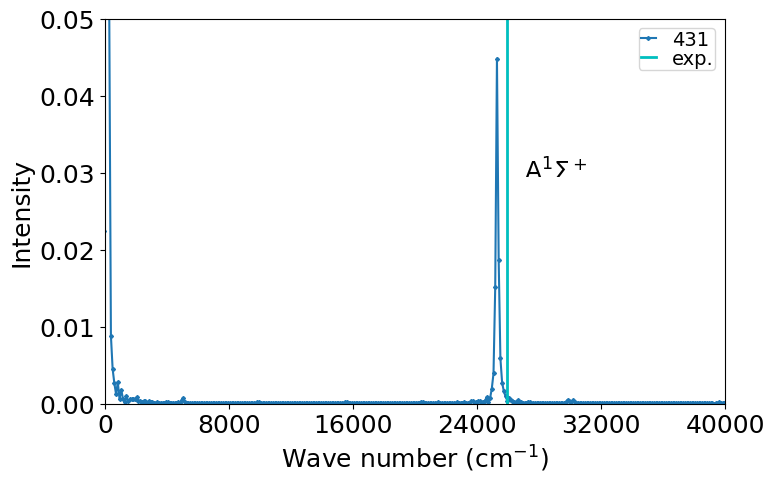

<Figure size 2000x1000 with 0 Axes>

In [10]:
n = 0
dataz = ['.']

myfft=zeros(n+1,dtype=ndarray)
myom=zeros(n+1,dtype=ndarray)

titles = ['431']
#titles = tuple(titles)
    
for i in range(n+1):
     myfft[i], myom[i] = fftw_transform(dataz[i], 'acf', lfreq=None, dohhg=False, mhohg = False, append='')


plot_aucofu(myom,myfft,"LiH_plots",titles,xmin=-0.1,xmax=40000,ymin=0,ymax=0.05)
plt.show()





